In [1]:
"""
Created on Thu Jan 11 21:13:20 2024

PCA and SVC

@author: ganchenko
"""

from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import random
from matplotlib import pyplot as plt 
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


# Helpfull functions
The functions for image plotting.

In [2]:
def compute_test_acc_svm(test_y, pred_test_y):
    return np.mean(pred_test_y == test_y)

def plot_digits(X, img_pix, n, labels_predict=np.array([None]), labels_act=np.array([None]), rnd=True):
    """
    Plot n*n random digits from dataset
    
    Args:
        X -  (num, img_pix*img_pix), array of digits
        img_pix - int, size of the digit img_pix*img_pix
        n - int, n is a number of columns and rows
        labels_predicted - (num, ) of int or str with predicted labels
        labels_act - (num, ) of int or str with actual labels
        rnd - Boolean, random chosing of samples
    Returns:
        nothing
    """
    plt.figure(figsize=[1.5*n, 1.5*n])
   
    for i in range(n*n):
        plt.subplot(n , n, i+1)
        if rnd:
            indx=random.randint(0, X.shape[0]-1)
        else:
            indx=i
        dig=X[indx, :].reshape(img_pix, img_pix)
        plt.imshow(dig, cmap='gray_r')
        plt.axis('off')
        str_title=''
        if labels_act[0]!=None: str_title+=' Act_num: '+str(labels_act[indx])+', \n'
        if labels_predict[0]!=None: str_title+='Pre_num: '+str(labels_predict[indx])
        plt.title(str_title)
            
    plt.tight_layout()        
    plt.show()       

def plot_pca_digits(X, pcs, img_pix, n, labels_predict=np.array([None]), labels_act=np.array([None])):
    """
    Plot n random digits from dataset in comparison with PCA projections
    
    Args:
        X -  (num, img_pix*img_pix), array of digit images
        pcs - sklearn transformer PCA fited with X
        img_pix - int, size of the digit img_pix*img_pix
        n - int, n is a number of columns and rows
        labels_predicted - (num, ) of int or str with predicted labels
        labels_act - (num, ) of int or str with actual labels
    Returns:
        nothing
    """
    plt.figure(figsize=[1.5*2, 1.5*n])
   
    for i in range(n):
        
        indx=random.randint(0, X.shape[0]-1)
        X_orig=X[indx].reshape(1, img_pix**2)
        X_pca=pcs.transform(X_orig) #pca-transform of original image data
        X_pca_recon=np.dot(X_pca, pcs.components_) #reconstruct image from tranformed data
        X_pca_recon+=X.mean(axis=0) #return to uncentered data
        
        plt.subplot(n , 2, 2*i+1)
        dig=X_orig.reshape(img_pix, img_pix)
        plt.imshow(dig, cmap='gray_r')
        plt.axis('off')
        str_title=''
        if labels_act[0]!=None: str_title+=' Act_num: '+str(labels_act[indx])+', \n'
        if labels_predict[0]!=None: str_title+='Pre_num: '+str(labels_predict[indx])
        plt.title(str_title)
        
        plt.subplot(n , 2, 2*i+2)
        dig=X_pca_recon.reshape(img_pix, img_pix)
        plt.imshow(dig, cmap='gray_r')
        plt.axis('off')
            
    plt.tight_layout()        
    plt.show()       



# Import data

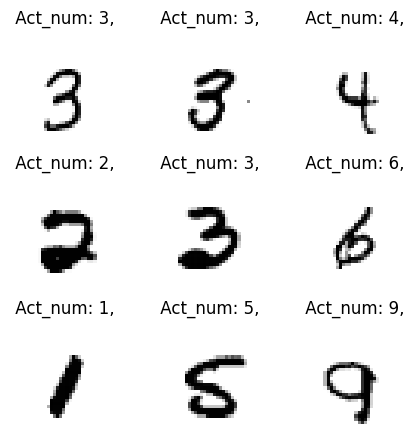

In [3]:
all_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
y=all_data.label.to_numpy(dtype='int32')

img_pix=28

X=all_data.drop(['label'], axis=1, inplace=False).to_numpy(dtype='int32')

plot_digits(X, img_pix, 3, labels_act=y) #plot some digit samples

# Principal component analysis

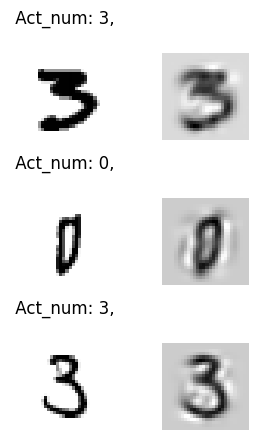

In [4]:
n_components=40

PCA_decomp = PCA(n_components=n_components)

PCA_decomp.fit(X)
features_mean = PCA_decomp.mean_

plot_pca_digits(X, PCA_decomp, img_pix, 3, labels_act=y) #plot several samples in comperison with pca projections

# Plot data in 2D spaces of the principal components

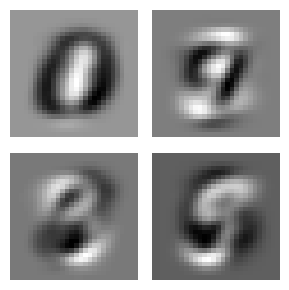

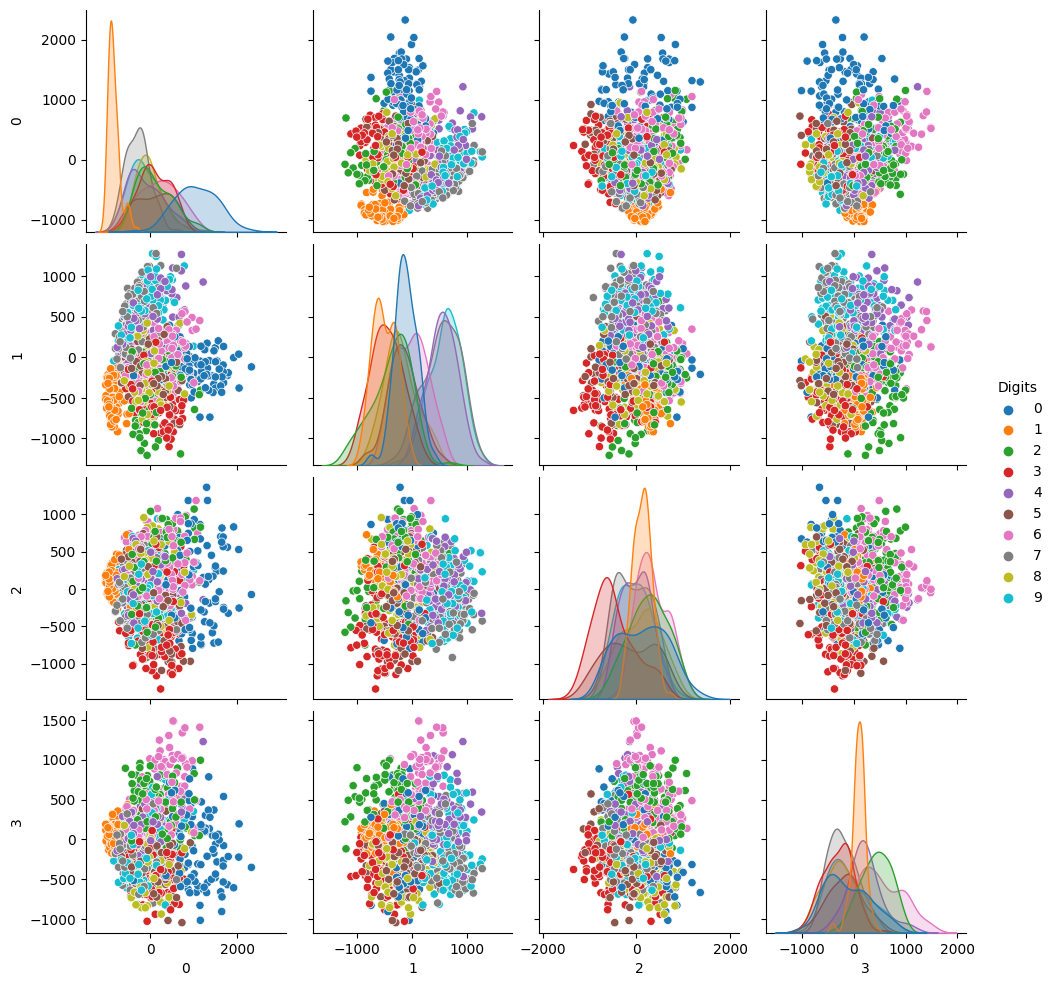

In [5]:
n_princ_comp=4
n_samples=1000

plot_digits(PCA_decomp.components_, img_pix, 2, rnd=False) #plot several principal components

X_centered = X-features_mean #centering data
indxs = np.arange(0,len(X_centered))
random.shuffle(indxs)
X_pca = np.matmul(X_centered[indxs[:n_samples], :], PCA_decomp.components_[:n_princ_comp,:].T)

X_pca_pd=pd.DataFrame(X_pca)

sns.pairplot(
    X_pca_pd.assign(Digits=y[indxs[:n_samples]]), 
    hue='Digits',
    diag_kind='kde', 
    palette='tab10'
    )
plt.show()


0 and 1 are very well separable even for only one component, while other digits is harder to distinguish

# Find optimal n_componets

100%|██████████| 10/10 [09:16<00:00, 55.67s/it]


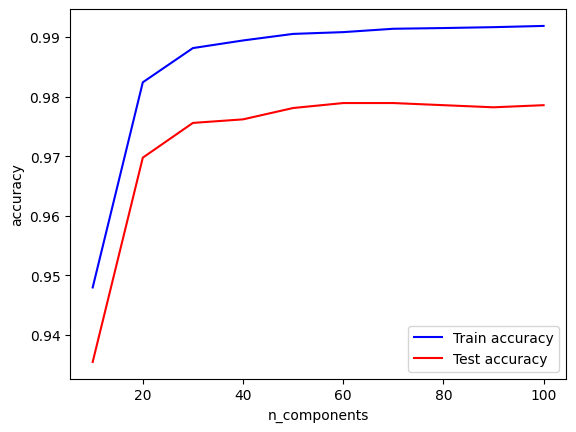

------------------------------
max train rate:  0.991875
max test rate:  0.9789285714285715


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = SVC(random_state = 42, kernel = 'rbf')

train_acc=[]
test_acc=[]
n_components_max=100
n_components_min=10
for k in tqdm(range(n_components_min, n_components_max+1,10)):
    clf=make_pipeline(PCA(n_components=k+1), model)
    clf.fit(X_train, y_train)

    predictions_train = clf.predict(X_train)
    predictions = clf.predict(X_test)

    train_acc.append(compute_test_acc_svm(y_train, predictions_train))
    test_acc.append(compute_test_acc_svm(y_test, predictions))

plt.plot(np.arange(n_components_min, n_components_max+1,10), train_acc, 'b', label='Train accuracy')
plt.plot(np.arange(n_components_min, n_components_max+1,10), test_acc, 'r', label='Test accuracy')
plt.xlabel('n_components')
plt.ylabel('accuracy')
plt.legend()
plt.show()

#plot_random_digits(X_test, img_pix, 3, labels_act=y_test, labels_predict=predictions)

print(30*'-')
print('max train rate: ', max(train_acc))
print('max test rate: ', max(test_acc))

As we can see no more 40 components are needed for good enough accuracy.

# Final training, test prediction and submission

In [7]:
model = make_pipeline(PCA(n_components=40), SVC(kernel = 'rbf'))
model.fit(X, y)

predictions_train=model.predict(X)
train_acc_full=compute_test_acc_svm(y, predictions_train)

test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")

X_test=test_data.to_numpy(dtype='int32')
predictions=model.predict(X_test)

output = pd.DataFrame({'ImageId': range(1, len(X_test)+1), 'Label': predictions})
output.to_csv('submission.csv', index=False)